In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from base_learning import BaseLearning
import random
import matplotlib.pyplot as plt

In [111]:
import gym
import numpy as np
from env_v1 import BlackjackEnv
from env_v3 import BlackjackDoubleDownSplitEnv

In [140]:
#Creation du modèle de DL

class DQNSolver(nn.Module):
    """
    Convolutional Neural Net with 3 conv layers and two linear layers
    """
    def __init__(self, input_shape, n_actions):
        super(DQNSolver, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_shape, 30),
            nn.ReLU(),
            nn.Linear(30, n_actions)
        )
    

    def forward(self, x):
        #x = self.fc(x)#.view(x.size()[0], -1)
        return self.fc(x)


In [141]:
class DQNAgent:

    def __init__(self, env, max_memory_size, batch_size, gamma, lr, epsilon):

        # Define DQN Layers
        self.env = env
        self.state_space = len(env.observation_space)
        self.action_space = env.action_space.n
        #self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # DQN network  
        self.dqn = DQNSolver(self.state_space, self.action_space).to(self.device)
        
        self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)

        # Create memory
        self.max_memory_size = max_memory_size
        self.STATE_MEM = torch.zeros(max_memory_size, self.state_space)
        self.ACTION_MEM = torch.zeros(max_memory_size, 1)
        self.REWARD_MEM = torch.zeros(max_memory_size, 1)
        self.STATE2_MEM = torch.zeros(max_memory_size, self.state_space)
        self.DONE_MEM = torch.zeros(max_memory_size, 1)
        self.ending_position = 0
        self.num_in_queue = 0
        
        self.memory_sample_size = batch_size
        
        # Learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) 
        self.epsilon = epsilon

    def remember(self, state, action, reward, state2, done):
        """Store the experiences in a buffer to use later"""
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)
    
    def batch_experiences(self):
        """Randomly sample 'batch size' experiences"""
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]      
        return STATE, ACTION, REWARD, STATE2, DONE
    
    def act(self, state, train):
        """Epsilon-greedy action"""
        if (random.random() < self.epsilon) and train:  
            return torch.tensor([[env.action_space.sample()]])
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
    
    def experience_replay(self):
        if self.memory_sample_size > self.num_in_queue:
            return
    
        # Sample a batch of experiences
        STATE, ACTION, REWARD, STATE2, DONE = self.batch_experiences()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
        target = REWARD + torch.mul((self.gamma * self.dqn(STATE2).max(1).values.unsqueeze(1)), 1 - DONE)
        current = self.dqn(STATE).gather(1, ACTION.long())
        
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        #self.exploration_rate *= self.exploration_decay
    def run(self,num_episodes,train):
        total_rewards = []
        win = 0
        draw = 0
        loss = 0
        for ep_num in range(num_episodes):
            state = list(self.env.reset())
            state = torch.Tensor([state])
            total_reward = 0
            steps = 0
            while True:
                action = self.act(state,train)
                steps += 1
                
                state_next, reward, terminal, info = self.env.step(int(action[0]))
                total_reward += reward
                state_next = torch.Tensor([state_next])
                reward = torch.tensor([reward]).unsqueeze(0)
                
                terminal = torch.tensor([int(terminal)]).unsqueeze(0)
                
                if(train):
                    self.remember(state, action, reward, state_next, terminal)
                    self.experience_replay()
                
                state = state_next
                if terminal:
                    #total_reward+=1
                    if reward == 0:
                        draw += 1
                    elif reward > 0:
                        win += 1
                    else:
                        loss += 1
                    break
            
            total_rewards.append(total_reward)
            
            if ep_num != 0 and ep_num % 1000 == 0:
                print("Episode {} score = {}, average score = {}".format(ep_num + 1, total_rewards[-1], np.mean(total_rewards)))
            #num_episodes += 1
        if(not train):  
            print("win: {} | draw: {} | loss: {}".format(win/ num_episodes, draw / num_episodes, loss / num_episodes))
        #print("Episode {} score = {}, average score = {}".format(ep_num + 1, total_rewards[-1], np.mean(total_rewards)))
        return total_rewards
    
    def train(self,num_episodes):
        return self.run(num_episodes,True)
    def test(self,num_episodes):
        return self.run(num_episodes,False)
        


In [142]:
env3 = BlackjackDoubleDownSplitEnv()
env1 = BlackjackEnv()

In [143]:
 # can change the environmeent accordingly
agent = DQNAgent(env3,
                    max_memory_size=30000,
                    batch_size=32,
                    gamma=0.2,
                    lr=0.0025,
                    epsilon=0.01)

In [144]:
rewards = agent.train(50000)

Episode 1001 score = 1.0, average score = -0.4695304695304695
Episode 2001 score = -1.0, average score = -0.26686656671664166
Episode 3001 score = -1.0, average score = -0.21059646784405198
Episode 4001 score = -1.0, average score = -0.1802049487628093
Episode 5001 score = -1.0, average score = -0.16556688662267546
Episode 6001 score = 1.0, average score = -0.14730878186968838
Episode 7001 score = 1.0, average score = -0.13226681902585344
Episode 8001 score = -1.0, average score = -0.13248343957005373
Episode 9001 score = 1.0, average score = -0.12698589045661593
Episode 10001 score = 0.0, average score = -0.1136886311368863
Episode 11001 score = 1.0, average score = -0.11017180256340332
Episode 12001 score = 1.0, average score = -0.1044079660028331
Episode 13001 score = 1.0, average score = -0.10160756864856549
Episode 14001 score = -1.0, average score = -0.10206413827583743
Episode 15001 score = 1.0, average score = -0.10139324045063662
Episode 16001 score = 1.0, average score = -0.0

In [147]:
test_rewards = agent.test(20000)

Episode 1001 score = -1.0, average score = -0.10989010989010989
Episode 2001 score = 1.0, average score = -0.08395802098950525
Episode 3001 score = 1.0, average score = -0.07964011996001333
Episode 4001 score = 1.0, average score = -0.07398150462384404
Episode 5001 score = 1.0, average score = -0.07978404319136173
Episode 6001 score = 1.0, average score = -0.07782036327278787
Episode 7001 score = 0.0, average score = -0.07813169547207542
Episode 8001 score = -1.0, average score = -0.0811148606424197
Episode 9001 score = -1.0, average score = -0.08654593934007332
Episode 10001 score = -1.0, average score = -0.08709129087091291
Episode 11001 score = -1.0, average score = -0.07926552131624398
Episode 12001 score = -2.0, average score = -0.07649362553120573
Episode 13001 score = -1.0, average score = -0.07722482885931851
Episode 14001 score = 1.0, average score = -0.07842296978787229
Episode 15001 score = 1.0, average score = -0.07799480034664355
Episode 16001 score = 1.0, average score = 

[0.0,
 -1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 2.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 -1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 0.0,
 -1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 -1.0,
 0.0,
 1.0,
 0.0,
 -1.0,
 -1.0,
 0.0,
 -1.0,
 -1.0,
 0.0,
 1.0,
 -1.0,
 -1.0,
 0.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 -1.0,
 -1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,


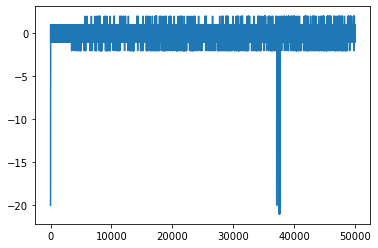

In [149]:
plt.plot(np.arange(1,50001),rewards)

In [131]:
rewards